# Custom NER with a bi-LSTM in Keras

This notebook shows how to extract information from text documents with the deep learning framework **[tensorflow](https://www.tensorflow.org')** and its high-level API **[keras](https://www.tensorflow.org/api_docs/python/tf/keras)**: We

- **prepare** the data,
- **build** a bi-LSTM model,
- **train** and
- **evaluate** the model.


## Load and preprocess the data

We load one file for training and one for validation, and store the samples as a list of token-tag pairs:

In [1]:
def load_data(filename: str):
    with open(filename, 'r') as file:
        split_lines = [line[:-1].split() for line in file]
    samples, start = [], 0
    for end, parts in enumerate(split_lines):
        if not parts:
            samples.append(split_lines[start:end])
            start = end + 1
    if start < end:
        samples.append(split_lines[start:end])
    return [[(token, tag.split('-')[-1])for token, tag in sample] for sample in samples ]

TRAIN_FILE = 'data/legal/01_raw/bag.conll'
train_samples = load_data(TRAIN_FILE)

VAL_FILE = 'data/legal/01_raw/bgh.conll'
val_samples = load_data(VAL_FILE)

len(train_samples), len(val_samples)

(12791, 5858)

In [2]:
train_samples[3][:14]

[('Die', 'O'),
 ('beabsichtigte', 'O'),
 ('Klage', 'O'),
 ('auf', 'O'),
 ('Entschädigung', 'O'),
 ('wegen', 'O'),
 ('der', 'O'),
 ('Dauer', 'O'),
 ('des', 'O'),
 ('Verfahrens', 'RS'),
 ('vor', 'RS'),
 ('dem', 'RS'),
 ('Bundesarbeitsgericht', 'RS'),
 ('zum', 'RS')]

We determine the set of all tags that occur, and add an extra tag `_` for untagged token:

In [3]:
def get_schema(samples):
    return ['_'] + sorted({tag for sentence in samples for _, tag in sentence})

schema = get_schema(train_samples + val_samples)
print(' '.join(schema))

_ AN EUN GRT GS INN LD LDS LIT MRK O ORG PER RR RS ST STR UN VO VS VT


Next, we represent

- each token by a word vector taken from a german language model provided by [spaCy](https://spacy.io).
- each tag by its index in the schema.


In [4]:
!python3 -m spacy download de_core_news_md

2021-09-30 09:56:09.935519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-30 09:56:09.935542: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 47.8 MB 14.0 MB/s eta 0:00:01     |███████████████▎                | 22.9 MB 12.8 MB/s eta 0:00:02
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


In [5]:
import spacy
import numpy as np
from tqdm import tqdm

MAX_LEN = 50

nlp = spacy.load('de_core_news_md')
EMB_DIM = nlp.vocab.vectors_length

def preprocess(schema, samples):
    tag_index = {tag: index for index, tag in enumerate(schema)}
    X = np.zeros((len(samples), MAX_LEN, EMB_DIM), dtype=np.float32)
    y = np.zeros((len(samples), MAX_LEN), dtype=np.uint8)
    vocab = nlp.vocab
    for i, sentence in tqdm(enumerate(samples)):
        for j, (token, tag) in enumerate(sentence[:MAX_LEN]):
            X[i, j] = vocab.get_vector(token)
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(schema, train_samples)
X_val, y_val = preprocess(schema, val_samples)


2021-09-30 09:56:18.562701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-30 09:56:18.562716: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
12791it [00:00, 14683.08it/s]
5858it [00:00, 13148.21it/s]


In [6]:
X_train.shape, y_train.shape

((12791, 50, 300), (12791, 50))

In [7]:
y_train[5,:14]

array([10, 10,  3, 10, 10,  4,  4,  4,  4,  4,  4,  4, 10,  4],
      dtype=uint8)

In [8]:
train_samples[5][:14]

[('1.', 'O'),
 ('Das', 'O'),
 ('Bundesarbeitsgericht', 'GRT'),
 ('ist', 'O'),
 ('gemäß', 'O'),
 ('§', 'GS'),
 ('9', 'GS'),
 ('Abs.', 'GS'),
 ('2', 'GS'),
 ('Satz', 'GS'),
 ('2', 'GS'),
 ('ArbGG', 'GS'),
 ('iVm.', 'O'),
 ('§', 'GS')]

In [9]:
schema.index('GRT')

3

In [10]:
schema.index('RS')

14

## Build the bi-LSTM model

The high-level API [Keras](https://keras.io) of [tensorflow](https://www.tensorflow.org) allows us to
build, train and apply a bi-LSTM model with just a few lines.

The following picture summarizes the model layers involved:

![](img/bilstm.svg)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, TimeDistributed, Dense

def build_model(filters=256):
    input_shape = (MAX_LEN, EMB_DIM)
    bi_lstm = Bidirectional(LSTM(filters, return_sequences=True), input_shape = input_shape)
    classifier = TimeDistributed(Dense(len(schema), activation='softmax'))
    model = Sequential([bi_lstm, classifier])
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
    print(model.summary())
    return model

model = build_model(512)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 50, 1024)          3330048   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 21)            21525     
Total params: 3,351,573
Trainable params: 3,351,573
Non-trainable params: 0
_________________________________________________________________
None


## Train the model

Now we have everything at hand to train our model:

In [14]:
import pandas as pd
import mlflow 

def train(model, nr_samples=-1, epochs=10, batch_size=32):
    mlflow.set_experiment('legal-ner')
    with mlflow.start_run():
        mlflow.keras.autolog()
        history = model.fit(X_train[:nr_samples], y_train[:nr_samples],
                            validation_split=0.2, epochs=epochs, batch_size=batch_size)
    return model, pd.DataFrame(history.history)


In [15]:
model, history = train(model)
history

/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py:411: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)
2021-09-30 09:56:37.659918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
320/320 [==============================] - 118s 365ms/step - loss: 0.0829 - accuracy: 0.9801 - val_loss: 0.0463 - val_accuracy: 0.9866
Epoch 2/10
320/320 [==============================] - 119s 371ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.0403 - val_accuracy: 0.9881
Epoch 3/10
320/320 [==============================] - 128s 400ms/step - loss: 0.0136 - accuracy: 0.9957 - val_loss: 0.0412 - val_accuracy: 0.9887
Epoch 4/10
320/320 [==============================] - 133s 415ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0382 - val_accuracy: 0.9891
Epoch 5/10
320/320 [==============================] - 141s 440ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0440 - val_accuracy: 0.9888
Epoch 6/10
320/320 [==============================] - 182s 567ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0447 - val_accuracy: 0.9894
Epoch 7/10
320/320 [==============================] - 126s 393ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0467 -

2021-09-30 10:18:50.524235: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp6fy1hyc9/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp6fy1hyc9/model/data/model/assets


loss  accuracy  val_loss  val_accuracy
0  0.082932  0.980107  0.046324      0.986560
1  0.024110  0.992813  0.040277      0.988131
2  0.013612  0.995733  0.041179      0.988694
3  0.007622  0.997754  0.038158      0.989070
4  0.004157  0.998810  0.043951      0.988812
5  0.003268  0.999122  0.044749      0.989414
6  0.001741  0.999582  0.046670      0.989609
7  0.001244  0.999758  0.044444      0.989719
8  0.000946  0.999844  0.046896      0.989851
9  0.000798  0.999844  0.048369      0.989805

Let us visualize the training history:

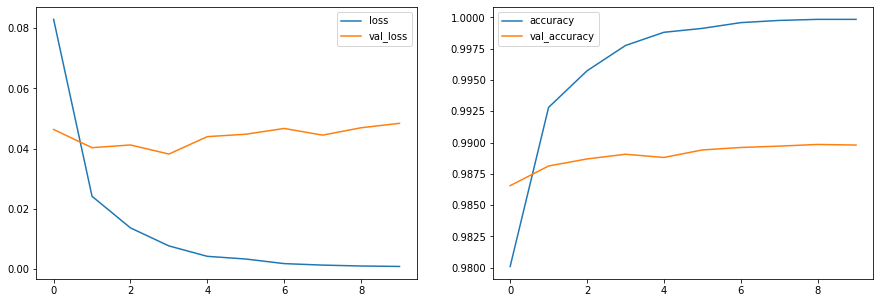

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    history[['loss', 'val_loss']].plot.line(ax=ax1)
    history[['accuracy', 'val_accuracy']].plot.line(ax=ax2)

plot_history(history)

## Evaluation

To evaluate the performance of our model, we apply it to our validation data.

For each sample and each token, we 

- obtain a probability distribution on the schema (see `y_probs`),
- take the tag with maximal probability as the prediction (see `y_pred`),
- store the token, the true tag and the predicted tag (see `pred_samples`).


In [17]:
def predict(model):
    y_probs = model.predict(X_val)
    print(y_probs.shape)
    y_pred = np.argmax(y_probs, axis=-1)
    pred_samples = [
        [(token, tag, schema[index]) for (token, tag), index in zip(sentence, tag_pred)]
        for sentence, tag_pred in zip(val_samples, y_pred)
    ]
    return pred_samples

pred_samples = predict(model)


(5858, 50, 21)


Let's see what the predictions look like:

In [18]:
pd.DataFrame.from_records(pred_samples[14][:30], columns=['Token', 'Truth', 'Prediction'])

Token Truth Prediction
0             Über     O          O
1             eine     O          O
2              zum     O          O
3           Führen     O          O
4              des     O          O
5   Kraftfahrzeugs     O          O
6    erforderliche     O          O
7    Fahrerlaubnis     O          O
8         verfügte     O          O
9              der     O          O
10      Angeklagte     O          O
11           nicht     O          O
12               .     O          O

To **evaluate** our model, we consider 

- for each tag
- the one-vs-all binary classification problem 
- of marking every token by this one tag or any other, 


and look at the *recall*, *precision* and *f1-score* of this binary classification problem.

All this is already implemented in scikit-learn:

In [19]:
from sklearn.metrics import classification_report

def evaluate(pred_samples):
    y_t = [pos[1] for sentence in pred_samples for pos in sentence]
    y_p = [pos[2]for sentence in pred_samples for pos in sentence]
    report = classification_report(y_t, y_p, output_dict=True)
    return pd.DataFrame.from_dict(report).transpose().reset_index()

scores = evaluate(pred_samples)
print(scores)


/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           index  precision    recall  f1-score       support
0             AN   0.000000  0.000000  0.000000      52.00000
1            EUN   0.776952  0.525126  0.626687     398.00000
2            GRT   0.894286  0.486781  0.630413     643.00000
3             GS   0.962842  0.914231  0.937907    6774.00000
4            INN   0.891892  0.277311  0.423077     119.00000
5             LD   0.556452  0.802326  0.657143      86.00000
6            LDS   0.000000  0.000000  0.000000       9.00000
7            LIT   0.664316  0.840571  0.742122    1681.00000
8            MRK   0.000000  0.000000  0.000000      49.00000
9              O   0.981152  0.992101  0.986596  133429.00000
10           ORG   0.384615  0.188679  0.253165     159.00000
11           PER   0.166667  0.002114  0.004175     473.00000
12            RR   0.932234  0.908929  0.920434     560.00000
13            RS   0.952337  0.863126  0.905540    8380.00000
14            ST   0.800000  0.405063  0.537815      79.00000
15      

/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

Let's also plot the scores:

In [20]:
import altair as alt

def plot(scores):
    base =  alt.Chart(scores[:-4]).encode(x=alt.X('support', scale=alt.Scale(type='log')), y='f1-score',
                                          tooltip=['index', 'support', 'recall', 'precision', 'f1-score'])
    return base.mark_point().encode(color='index') + base.mark_text().encode(text='index')

plot(scores)

alt.LayerChart(...)

In [21]:
with mlflow.start_run():
    scores.to_csv('scores.csv')
    mlflow.log_artifact('scores.csv')
    df = scores.set_index('index')
    for avg in ('macro avg', 'weighted avg'):
        mlflow.log_metric(avg + ' f1-score', df.loc[avg, 'f1-score'])

## Training with imbalanced data

In [22]:
import random
from typing import Any, Dict, List, Sequence, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
from pydantic import BaseModel, Field


class SequenceParams(BaseModel):
    """Parameters for generating batches."""

    batch_size: int
    batches_per_epoch: int
    uniform_sampling: bool


class DynamicSequence(tf.keras.utils.Sequence):
    """Sequence that generates batches dynamically."""

    def __init__(self, X: pd, y: np.ndarray, params: SequenceParams):
        self.X = X
        self.y = y
        self.partitions = get_partitions(y)
        self.params = params.copy()

    def __len__(self):
        return self.params.batches_per_epoch

    def __getitem__(self, index: int) -> Tuple[Dict[str, np.ndarray], np.ndarray]:
        if self.params.uniform_sampling:
            idxs = sample_uniform(self.partitions, self.params.batch_size)
        else:
            idxs = random.choices(list(range(len(self.y))), k=self.params.batch_size)
        batch_x = self.X[idxs]
        batch_y = self.y[idxs]
        return batch_x, batch_y

    def on_epoch_end(self):
        pass


def get_partitions(y) -> Dict[Any, List[Any]]:
    """Return mapping from range of values to indices where they occur in sequence."""
    partitions: Dict[Any, List[Any]] = {}
    for idx, tags in enumerate(y):
        for tag in set(tags) - {schema.index('O')}:
            partitions[tag] = partitions.get(tag, []) + [idx]
    return partitions


def sample_uniform(partitions: Dict[Any, List[Any]], count: int) -> List[Any]:
    """Sample uniformly from partitions."""
    p_ids = random.choices(list(partitions.keys()), k=count)
    return [random.choice(partitions[p_id]) for p_id in p_ids]


In [25]:
def experiment(nr_samples=-1, epochs_1=5, epochs_2=2, batch_size=32, filters=256):
    model = build_model(filters=filters)
    mlflow.set_experiment('legal-ner')
    X = X_train[:nr_samples]
    y = y_train[:nr_samples]
    params = SequenceParams(batch_size=batch_size, batches_per_epoch=len(X) // batch_size, uniform_sampling=True)
    with mlflow.start_run():
        mlflow.keras.autolog()
        mlflow.log_params(dict(epochs_uniform=epochs_1, epochs_proportional=epochs_2, nr_samples=len(X), filters=filters))
        if epochs_1:
            seq_1 = DynamicSequence(X, y, params)
            model.fit(seq_1, epochs=epochs_1, validation_data=(X_val, y_val))
        if epochs_2:
            params.uniform_sampling = False
            seq_2 = DynamicSequence(X, y, params)
            model.fit(seq_2, epochs=epochs_2, validation_data=(X_val, y_val))
        scores = evaluate(predict(model)).set_index('index')
        for avg in ('macro avg', 'weighted avg'):
            mlflow.log_metric(avg + ' f1-score', scores.loc[avg, 'f1-score'])
        print(scores)
        scores.reset_index().to_csv('scores.csv')
        mlflow.log_artifact('scores.csv')
    return model

total_epochs = 10
for epochs_1 in [10, 8, 4, 0]:
    experiment(epochs_1=epochs_1, epochs_2 = total_epochs-epochs_1, filters=512)
    


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 50, 1024)          3330048   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 21)            21525     
Total params: 3,351,573
Trainable params: 3,351,573
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
399/399 [==============================] - 152s 376ms/step - loss: 0.0844 - accuracy: 0.9796 - val_loss: 0.0819 - val_accuracy: 0.9769
Epoch 2/10
399/399 [==============================] - 166s 415ms/step - loss: 0.0136 - accuracy: 0.9964 - val_loss: 0.0746 - val_accuracy: 0.9811
Epoch 3/10
399/399 [==============================] - 176s 442ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0885 - val_accuracy: 0.9805
Epoch 4/10
399/399 [==============================] - 184s 462m

INFO:tensorflow:Assets written to: /tmp/tmpai_t2471/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpai_t2471/model/data/model/assets


(5858, 50, 21)


/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

              precision    recall  f1-score       support
index                                                    
AN             0.000000  0.000000  0.000000      52.00000
EUN            0.524823  0.557789  0.540804     398.00000
GRT            0.873016  0.513219  0.646425     643.00000
GS             0.957268  0.922645  0.939638    6774.00000
INN            0.415094  0.184874  0.255814     119.00000
LD             0.535032  0.976744  0.691358      86.00000
LDS            0.000000  0.000000  0.000000       9.00000
LIT            0.675688  0.861392  0.757322    1681.00000
MRK            0.000000  0.000000  0.000000      49.00000
O              0.983285  0.991554  0.987402  133429.00000
ORG            0.310345  0.226415  0.261818     159.00000
PER            0.666667  0.067653  0.122841     473.00000
RR             0.940631  0.905357  0.922657     560.00000
RS             0.950338  0.856325  0.900885    8380.00000
ST             0.480000  0.607595  0.536313      79.00000
STR           

/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py:411: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


Epoch 1/8
399/399 [==============================] - 169s 419ms/step - loss: 0.0892 - accuracy: 0.9784 - val_loss: 0.0654 - val_accuracy: 0.9814
Epoch 2/8
399/399 [==============================] - 205s 513ms/step - loss: 0.0114 - accuracy: 0.9970 - val_loss: 0.0673 - val_accuracy: 0.9818
Epoch 3/8
399/399 [==============================] - 163s 409ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0823 - val_accuracy: 0.9800
Epoch 4/8
399/399 [==============================] - 171s 429ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 0.0841 - val_accuracy: 0.9819
Epoch 5/8
399/399 [==============================] - 162s 404ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0783 - val_accuracy: 0.9822
Epoch 6/8
399/399 [==============================] - 168s 419ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0805 - val_accuracy: 0.9822
Epoch 7/8
399/399 [==============================] - 165s 415ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0846 - val_ac

INFO:tensorflow:Assets written to: /tmp/tmpbpj0tkyp/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpbpj0tkyp/model/data/model/assets
2021/09/30 11:14:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='8' for run ID='4830617b1ae841af921bc71b8d134495'. Attempted logging new value '2'.


Epoch 1/2
399/399 [==============================] - 154s 387ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0877 - val_accuracy: 0.9825
Epoch 2/2
399/399 [==============================] - 181s 453ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0855 - val_accuracy: 0.9832
(5858, 50, 21)


/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

              precision    recall  f1-score        support
index                                                     
AN             0.000000  0.000000  0.000000      52.000000
EUN            0.618076  0.532663  0.572200     398.000000
GRT            0.896266  0.335925  0.488688     643.000000
GS             0.961592  0.920283  0.940484    6774.000000
INN            0.474576  0.235294  0.314607     119.000000
LD             0.610294  0.965116  0.747748      86.000000
LDS            0.000000  0.000000  0.000000       9.000000
LIT            0.604254  0.861987  0.710468    1681.000000
MRK            0.000000  0.000000  0.000000      49.000000
O              0.980357  0.993090  0.986682  133429.000000
ORG            0.303279  0.232704  0.263345     159.000000
PER            0.333333  0.002114  0.004202     473.000000
RR             0.950092  0.917857  0.933697     560.000000
RS             0.964758  0.836277  0.895935    8380.000000
ST             0.795455  0.443038  0.569106      79.0000

/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py:411: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


Epoch 1/4
399/399 [==============================] - 157s 389ms/step - loss: 0.0875 - accuracy: 0.9781 - val_loss: 0.0730 - val_accuracy: 0.9797
Epoch 2/4
399/399 [==============================] - 168s 422ms/step - loss: 0.0118 - accuracy: 0.9969 - val_loss: 0.0713 - val_accuracy: 0.9811
Epoch 3/4
399/399 [==============================] - 170s 426ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0710 - val_accuracy: 0.9829
Epoch 4/4
399/399 [==============================] - 158s 396ms/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0733 - val_accuracy: 0.9824


INFO:tensorflow:Assets written to: /tmp/tmpki03ld75/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpki03ld75/model/data/model/assets
2021/09/30 11:31:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='4' for run ID='5d748cee9b25483b80c8396e48095fc4'. Attempted logging new value '6'.


Epoch 1/6
399/399 [==============================] - 155s 387ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0683 - val_accuracy: 0.9832
Epoch 2/6
 32/399 [=>............................] - ETA: 4:07 - loss: 0.0078 - accuracy: 0.9976

KeyboardInterrupt: 